<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/HKStocksCorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pair strategy is a type of **relative value** strategies or **statistical arbitrage**
which rely on the **mean-reversion** of prices to the asset's fair value.
They assume that prices only temporarily move away from fair value due to behavioral effects
like overreaction or herding, or liquidity effects such as temporary market impact or long-term supply/demand friction.



*   Find the price **correlated** HK stocks in **same sector** for Pair strategy
*   Buy the stock when it is relatively **under-priced** to the correlated stock and sell the corresponding **over-priced** stock
*   As they're price correlated (statistically), assume they will go back to the similar price ratio later (mean reversion)
*   Hence (hopefully), the under-priced stock (bought) will goes up later while the over-priced (sold) one will drop


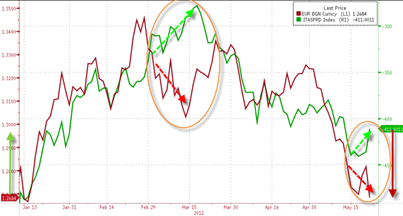

In [ ]:
#@title Execute this block for a temporary yfinance fix
!pip install yfinance==0.2.61

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Choose the language to display the stock names and run this block to import libraries and helper functions

language = 'English' #@param ["English", "Chinese"]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')
%matplotlib inline

# Yahoo Finance
import yfinance as yf

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

import ipywidgets as widgets
from IPython.display import display, clear_output


# 20220202: Temp workaround for the pandas upgrade
# !pip install --upgrade openpyxl

### Helper functions
# Display the stock info in Chinese or not
def useChinese(use=True):
  # return STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE
  if use:
    return 'hkStocksQuotesChi.xlsx', 'researchHKStocksAdjClosePxChi.csv', 'testHKStocksAdjClosePxChi.csv'

  else:
    return 'hkStocksQuotes.xlsx', 'researchHKStocksAdjClosePx.csv', 'testHKStocksAdjClosePx.csv'


STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])

  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05):
  tradingParams = {}
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# Currently one dollarValue will be used for all the trade
# Future improvement can adjust the dollarValue per entry signals
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB, dollarValue=10000, stopLoss=0):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calc the stopLoss value
  if stopLoss > 0:
    stopLossUp = shortA_longB_ratio * (1 + stopLoss)
    stopLossDown = longA_shortB_ratio * (1 - stopLoss)

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue #one dollarValue will be used for all the trade

  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # If hit the stopLoss, will exit the trade entirely
    if stopLoss > 0 and (pxRatio > stopLossUp or pxRatio < stopLossDown):
      break

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, threshold=0.05, dollarValue=10000, stopLoss=0, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB, threshold)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB, dollarValue, stopLoss)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


### Calculate PnL related functions
TRADING_DAYS_IN_YEARS = 256

# Calculate the PnL of the Pair portfolio
def calcPortfolio(pairsBackTest, interestRate=0.03, commRate=0.005):
	portfolio = []
	portfolioPnl = 0

	for backtestDf in pairsBackTest:
		stats, pnlDf = calcPnl(backtestDf, interestRate, commRate)
		pnl = stats['tradingPnL'] - stats['shortInterest'] - stats['transCost']

		stockA = backtestDf.columns[0]
		stockB = backtestDf.columns[1]
		print("{} vs {} ---> ${}".format(stockA, stockB, pnl))

		portfolio.append([stockA, stockB, stats['tradingPnL'], stats['shortInterest'], stats['transCost'], pnl])
		portfolioPnl += pnl

	print("=================================================================")
	print('PortfolioPnl: $', portfolioPnl)
	portfolioDf = pd.DataFrame(portfolio, columns=['stockA', 'stocksB', 'tradingPnL', 'shortInterest', 'transCost', 'Pnl'])
	return portfolioPnl, portfolioDf


# Calculate the PnL of one Pair
def calcPnl(backTest_df, interestRate=0.03, commRate=0.005):
	dailyInterestRate = interestRate / TRADING_DAYS_IN_YEARS
	pnl_df = backTest_df.copy()

	pnl_df[['longPos', 'shortPos', 'longValue', 'shortValue', 'longPnl', 'shortPnl', 'shortInterest', 'transCost', 'pnl', 'totalPnl']] = 0
	signal, longPos, shortPos, longValue, shortValue, longPnl, shortPnl, shortInterest, transCost, pnl, accumPnl, totalPnl = 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0

	for index, row in pnl_df.iterrows():
		currentSignal = row['signal']
		transCost = 0

		# When trading signal is changed
		if currentSignal != signal:
			if currentSignal == 0:
				transCost = (curentLongValue + curentShortValue) * commRate
				longValue = 0
				shortValue = 0

			else:
				longValue = row['dollarValue']
				shortValue = row['dollarValue']
				transCost = (longValue + shortValue) * commRate

			longPos = getLongPos(currentSignal, longValue, row)
			shortPos = getShortPos(currentSignal, shortValue, row)

			longPnl = 0
			shortPnl = 0

			pnl = 0
			accumPnl = totalPnl

		#Store current row value
		pnl_df.loc[index, 'transCost'] = transCost

		pnl_df.loc[index, 'longPos'] = longPos
		pnl_df.loc[index, 'shortPos'] = shortPos

		curentLongValue = getLongValue(currentSignal, longPos, row)
		pnl_df.loc[index, 'longValue'] = curentLongValue

		curentShortValue = getShortValue(currentSignal, shortPos, row)
		pnl_df.loc[index, 'shortValue'] = curentShortValue

		currentLongPnl = curentLongValue - longValue
		pnl_df.loc[index, 'longPnl'] = currentLongPnl

		currentShortPnl = shortValue - curentShortValue
		pnl_df.loc[index, 'shortPnl'] = currentShortPnl

		if curentShortValue > 0:
			curentShortInterest = row['dollarValue'] * dailyInterestRate
		else:
			curentShortInterest = 0

		pnl_df.loc[index, 'shortInterest'] = curentShortInterest

		currentPnl = currentLongPnl + currentShortPnl
		pnl_df.loc[index, 'pnl'] = currentPnl

		totalPnl = accumPnl + currentPnl
		pnl_df.loc[index, 'totalPnl'] = totalPnl

		signal = currentSignal

	tradingPnL = pnl_df['totalPnl'].iloc[-1]

	stats = {}
	stats['tradingPnL'] = tradingPnL
	stats['shortInterest'] = pnl_df['shortInterest'].sum()
	stats['transCost'] = pnl_df['transCost'].sum()

	return stats, pnl_df


def getLongPos(signal, longValue, row):
	if longValue == 0 or signal == 0 : return 0
	if signal == -1: return longValue / row[0]
	if signal == 1: return longValue / row[1]


def getShortPos(signal, shortValue, row):
	if shortValue == 0 or signal == 0 : return 0
	if signal == -1: return shortValue / row[1]
	if signal == 1: return shortValue / row[0]


def getLongValue(signal, longPos, row):
	if longPos == 0 or signal == 0 : return 0
	if signal == -1: return longPos * row[0]
	if signal == 1: return longPos * row[1]


def getShortValue(signal, shortPos, row):
	if shortPos == 0 or signal == 0 : return 0
	if signal == -1: return shortPos * row[1]
	if signal == 1: return shortPos * row[0]


# 1. Source the stocks info

*   Source the **year 2020** stock data from **Yahoo finance**
*   Source the stock industries/sectors from **HKET**: http://www1.hket.com/finance/chart/industry-index.do


In [ ]:
#@title Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
if language == 'Chinese':
	STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(True)
else:
	 STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + STOCK_INFO_FILE)
stocksInfo

In [ ]:
#@title List the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)


In [ ]:
#@title List the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

# 2. **Stock Selection**:
Choose the set of the stocks that we are interested to trade in our portfolios


*   Not small names nor penny stocks
*   Has enough **liquidity** for trading purpose



In [ ]:
#@title Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

In [ ]:
#@title Input a minimum turnover value
MIN_TURNOVER = 100000000 #@param {type:"integer"}

# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover'
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

In [ ]:
#@title Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
#@title Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

#3. Source the **daily stock price** from **Yahoo Finance**

*   auto_adjust=True: The price is **adjusted**
*   Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
*   Stock dividends






In [ ]:
#@title Download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo Finance
startDate = '2020-01-01' #@param {type:"date"}
endDate = '2021-12-31' #@param {type:"date"}

allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")
data = yf.download(allStockCodes, start=startDate, end=endDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo['shortName']):
    if code in data:
      stocksDownload.append(data[code])
      columnNames.append(name)


# Drop down list for the stock names
stockDropdown = widgets.Dropdown(
    description = "Stock:",
    options = columnNames
)
display(stockDropdown)

In [ ]:
#@title Look at the downloaded stock price from the above drop-down list
company = stockDropdown.value

index = columnNames.index(company)
print(company)
stocksDownload[index]

Will only use the **close price** to form the strategy. To prevent **lookahead bias** and **overfit** the parameters, split the data into **Research** and **Test**

*   **Research Data**: Stock selection, pairs identification and the trading parameters (Entry / Exit) calculations

*   **Test Data**: back-test the strategy performance (such as PnL)


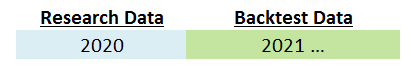

In [ ]:
#@title Choose the research and test period
Research_StartDate = '2020-01-01' #@param {type:"date"}
Research_EndDate = '2020-12-31' #@param {type:"date"}

Test_StartDate = '2021-01-01' #@param {type:"date"}
Test_EndDate = '2021-12-31' #@param {type:"date"}

# Combine the stocks closes into one pandas data frame
closes = [stock['Close'] for stock in stocksDownload]
stockCloses = pd.concat(closes, axis=1)
stockCloses.columns = columnNames

# To prevent lookahead bias, split the data into research period and test period
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting
researchData = stockCloses.loc[Research_StartDate : Research_EndDate]
testData = stockCloses.loc[Test_StartDate : Test_EndDate]

# Export the data to csv file for downloading
#researchData.to_csv(RESEARCH_AJD_CLOSE_FILE, encoding='utf_8_sig')
#testData.to_csv(TEST_AJD_CLOSE_FILE, encoding='utf_8_sig')

### In case the Yahoo stock download failed, read from the prepared csv file
#researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + RESEARCH_AJD_CLOSE_FILE, index_col=0)
#testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + TEST_AJD_CLOSE_FILE, index_col=0)
#columnNames = list(researchData.columns)

researchData

In [ ]:
#@title Pick 2 stocks to display the price correlation in the research period

def dropdown_eventhandler(change):
    clear_output()
    display(stockADropdown)
    display(stockBDropdown)
    plotPair(researchData, stockADropdown.value, stockBDropdown.value, CHART_SIZE_X, CHART_SIZE_Y)

# Drop down list for the stock names
stockADropdown = widgets.Dropdown(
    description="Stock A:",
    options=columnNames
)
display(stockADropdown)
stockADropdown.observe(dropdown_eventhandler)

stockBDropdown = widgets.Dropdown(
    description="Stock B:",
    options=columnNames,
    value = columnNames[1]
)
display(stockBDropdown)
stockBDropdown.observe(dropdown_eventhandler)

plotPair(researchData, stockADropdown.value, stockBDropdown.value, CHART_SIZE_X, CHART_SIZE_Y)

#4. Pair Identifications and Selections


*   Quantify the price correlation for all stock Pair combinations
*   Using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
*   The value is between 1 to -1 (**1**: perfectly positive correlated; **0**: No correlation; **-1**: perfectly negative correlated)

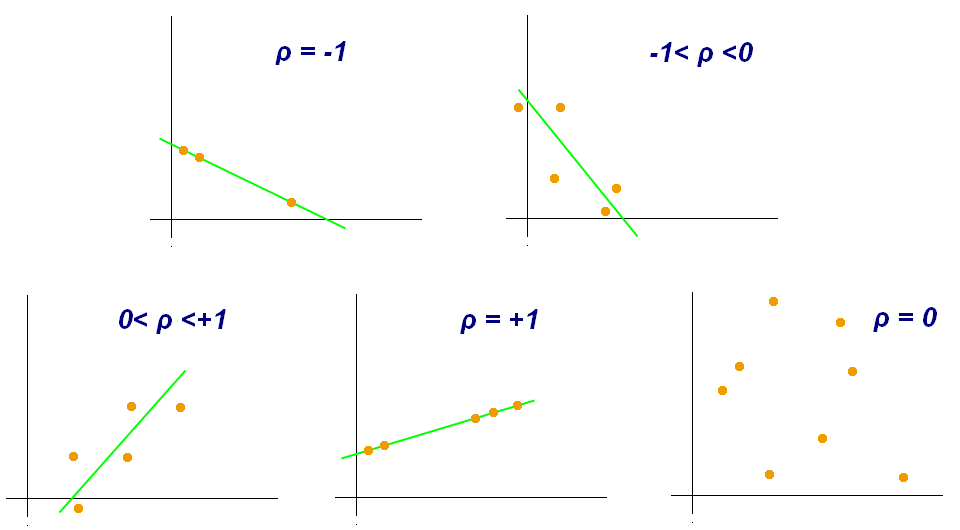

In [ ]:
#@title Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
#@title Plot the histogram of correlation frequencies among those stock pairs

# Flatten the correlation matrix and filter out self-correlations
correlation_values = stocksCorr.values.flatten()
correlation_values = correlation_values[correlation_values != 1]  # remove self-correlation
correlation_values = np.unique(correlation_values) # remove the duplicated pair correlation

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(correlation_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Frequencies')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Correlation')
plt.legend()
plt.show()

Pairs correlation distribution is left skewed. This means that more data points are concentrated on the right (i.e. having **more positive correlated pairs than the negative ones**). It is because the **stocks tends to move togehter with the board market direction**. It is another good exercise to study the highly negative correlated pairs

In [ ]:
#@title Filter the pairs with correlation values larger than the THRESHOLD

THRESHOLD = 0.9 #@param {type:"slider", min:0.5, max:1, step:0.01}
Same_Sector = False #@param {type:"boolean"}

pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

if Same_Sector:
  displayPairsDf = pairsDf[(pairsDf.sameSector == True)]
else:
  displayPairsDf = pairsDf

displayPairsDf.round(4)

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 34

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)


#5. Determine Trading Parameters (Entry/Exit Point) in **Research Period**
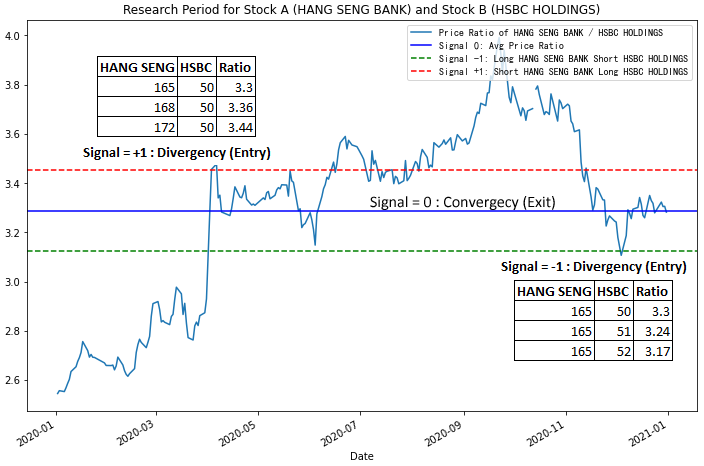

* **Price Ratio of Stock A/B**: the price relationship of stock A and B (Stock A price/ Stock B price) and it captures the **relative value**
* **Average Price Ratio of Stock A/B**: the average price ratio of the stock pair over the **research period** which represents **their long-term relationship**

* **Threshold**: define the **Divergence boundary** for trade **entry** points

* **Entry Point** (Divergence)

 * **Signal -1: Long *under-value* Stock A and Short *over-value* Stock B** when the price ratio **drops below the divergence threshold** than the average price ratio. It happens when stock A drops relatively more than stock B or stock A rises relatively less than stock B. Hence stock A is now relatively under-value to stock B

 * **Signal +1: Short *over-value* Stock A and Long *under-value* Stock B** when price ratio **rises above the divergence theshold** than the average price ratio. It happens when stock A drops relatively less than stock B or stock A rises relatively more than stock B. Hence stock A is now relatively over-value to stock B

* **Exit Point** (Convergence)

 * **Signal 0: Rewind the Position** if already created the above long/short positions, **reverse the above trade to close out the positions** when the stock pair price ratio **reverse back to the average price ratio**


In [ ]:
#@title Calculate the stock price ratios of (Stock A / Stock B) which represent the relative price value over the research period

pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

In [ ]:
#@title Calculate the trading parameters based on the Threadshold % in the research period
Threshold_percent = 5 #@param {type:"slider", min:0, max:100, step:1}
PX_RATIO_THRESHOLD = Threshold_percent / 100
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)
print("Threadhold %:", Threshold_percent)

# Plot the averge price ratio in research period
#labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelTitle = 'Research Period for Stock A and Stock B'
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio '
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

#6. Backtesting in **test period** and Calculate PnL
Backtest the strategy in the **test period** with the **trading parameters from research period**


* **Mark the signals (+1, -1, 0)** according to the Pair price ratio and the convergence / divengence threshold
* When (signal = +/-1), **enter the trade** by using the specified dollarValue to create positions (e.g. create \$10,000 long on Stock A and \$10,000 short positions on Stock B at the same time). Assume the execution is perfect and can long/short at equal dollar amount
* When (signal = 0), **exit the trade** by unwinding the open long/short positions (i.e. sell the long position and cover the short)
* **StopLoss** when the Pair price ratio is too much further away from the divergence. It could mean the underlying relationship of this Pair is brokern and needs to exit the trade with loss


Calculate the PnL


*   **Trading PnL**: when enter and exit the positions, calculate the profit or loss from the stocks execution price
*   **Trading cost**: based on the annual **short interest rate** and the **transaction cost** of buying and selling the stocks


In [ ]:
#@title Run back testing with different parameters

dollarValue = 10000 #@param {type:"number"}
stopLossPercent = 0 #@param {type:"slider", min:0, max:50, step:1}
shortInterestPercent = 3 #@param {type:"slider", min:0, max:20, step:0.01}
transactionPercent = 0.5 #@param {type:"slider", min:0, max:20, step:0.01}

print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")

# Backtest a Pair in test period
stopLoss = stopLossPercent / 100
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B, dollarValue, stopLoss)

# Calcuate the PnL in test period
shortInterest = shortInterestPercent / 100
transaction = transactionPercent / 100

pnl, pnl_df = calcPnl(backTest_df, shortInterest, transaction)
print(pnl)
print("*** PnL: {}".format(pnl['tradingPnL'] - pnl['shortInterest'] - pnl['transCost']))
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

#labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelTitle = 'Test Period for Stock A and Stock B'
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right', prop=CNFont)

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')


In [ ]:
#@title Run the entire Pair portfolio PnL

Same_Sector = True #@param {type:"boolean"}

# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == Same_Sector)]
print("Total pairs for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, PX_RATIO_THRESHOLD, dollarValue, stopLoss, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = calcPortfolio(pairsPortfolioBackTest,shortInterest, transaction)
pnlDf

# Notes
---
### **Pair Identifications and Selections**

Ideal properties of the pairs:

1. The pairs constituents are cointegrated.
2. The pairs reveals a mean-reverting character.
3. The pairs diverges and converges within convenient periods.
4. The pairs reverts to the mean with enough frequency.

This code uses the adjusted closing price and pandas default corr function (Pearson correlation coefficient) to determine the pairs correlations. However, it is generally more desirable to use **co-integration rather than correlation**.



* http://epchan.blogspot.com/2006/11/cointegration-is-not-same-as.html
* https://blog.quantinsti.com/pairs-trading-basics/
* https://kidquant.com/project/pairs-trading-strategies-in-python/


Pairs with stocks in the same sector share the same macro fundamental factors and prevent spurious correlation. However, it may be too restrictive and excludes some pairs opportunities. For example, "Photovoltaic Solar" and "Glass strands" may be correlated (upstream/downstream in the industry) but they're in different sectors

Use **clustering alogrithms** (such as k-mean or DBScan) to group similar stocks together and trade Pairs with the stocks from the same cluster

* https://blog.quantinsti.com/k-means-clustering-pair-selection-python/
* https://algotrading101.com/learn/cluster-analysis-guide/


---

### **Trading Parameters**
* **Ratio or Spread:** Stocks relationship can be expressed as **price spread** (Stock Price A - Stock Price B) rathan than price ratio (Stock Price A / Stock Price B).

* **Divergence Threshold:** Instead of using an arithmetic average price over the entire research period with a fixed percentage threshold, the divergence threshold is determined by a **z-score**. This z-score measures the number of **standard deviations** the current ratio/spread deviates from its **historical moving average**, calculated over a specific lookback period.

* **Improve strategy entry /exit points:** there's no guarantee that the point immediately after crossing the threshold is an optimal entry point. The spread might continue to diverge before converging again. Use **technincal indicators** (e.g. bollinger bands) or **Machine Learning** (e.g. decision tree, LSTM) to predict the price movements to improve the entry/exit.

* **Dynamic Stop Loss:** Prevent the stocks pair from diverging too much (may be the underlying relationship is broken due to some external events).

* **Position sizing:** dollar value for each pair trade can be different but need a way to determine the optimal amount.
